# Simulation of Magnetic Field Effects
- Jeff

Thinking about how to use B field around science cell to detune atoms in tweezers from scattering light from MOT


In [ ]:
### Useful functions
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import arc

# Physical constants (CODATA-ish values)
mu_B = 9.2740100783e-24       # J/T (Bohr magneton)
mu_N = 5.0507837461e-27       # J/T (nuclear magneton)
h = 6.62607015e-34            # J*s (Planck constant)
mu_B_over_h = mu_B / h        # Hz / T
mu_N_over_h = mu_N / h        # Hz / T


def ang_matrices(j):
    """Return angular momentum matrices (Jx, Jy, Jz) for a spin-j system (dimension 2j+1)."""
    dim = int(2*j + 1)
    m = np.arange(j, -j-1, -1)
    Jz = np.diag(m)
    Jp = np.zeros((dim, dim), dtype=complex)
    for i in range(dim-1):
        m_val = j - i
        coeff = np.sqrt((j - (m_val-1))*(j + (m_val)))
        Jp[i, i+1] = coeff
    Jm = Jp.T.conj()
    Jx = 0.5 * (Jp + Jm)
    Jy = -0.5j * (Jp - Jm)
    return Jx, Jy, Jz

def kron(a, b):
    return np.kron(a, b)

def build_hamiltonian(I, J, A_hz=0.0, B_hz=0.0, gJ=0.0, gI=0.0, B_field=0.0):
    """
    Build the full Hamiltonian (in Hz) for hyperfine + quadrupole (optional) + Zeeman terms
    in the uncoupled |mI, mJ> basis.
    
    Parameters:
        I, J : nuclear and electronic angular momenta (floats, e.g., I=1.5 for 3/2)
        A_hz : magnetic dipole hyperfine constant in Hz (A * I·J)
        B_hz : electric quadrupole hyperfine constant in Hz (use 0 to ignore)
        gJ : electronic g-factor for the level
        gI : nuclear g-factor for the nucleus (not simply mu_I; typically small)
        B_field : magnetic field in Tesla (float)
        
    Returns:
        H (ndarray) : Hamiltonian matrix in Hz (so eigenvalues are in Hz)
        basis_states (list of tuples) : list of (mI, mJ) in the ordering used
    """
    # Build angular momentum matrices for I and J
    Ix, Iy, Iz = ang_matrices(I)
    Jx, Jy, Jz = ang_matrices(J)
    dimI = Ix.shape[0]
    dimJ = Jx.shape[0]
    
    # Tensor-space operators (acting on |mI> x |mJ>)
    Iop_dot_Jop = kron(Ix, Jx) + kron(Iy, Jy) + kron(Iz, Jz)   # I·J operator
    Iz_op = kron(Iz, np.eye(dimJ))
    Jz_op = kron(np.eye(dimI), Jz)
    
    # Hyperfine term A I·J (A in Hz; operator in Hz)
    H_hf = A_hz * Iop_dot_Jop
    
    # Quadrupole term (if B_hz != 0) using standard textbook expression:
    # H_Q = B * [3(I·J)^2 + 3/2 (I·J) - I(I+1) J(J+1) ] / [2 I (2I-1) J (2J-1)]
    H_q = np.zeros_like(H_hf, dtype=complex)
    if B_hz != 0.0:
        denom = 2.0 * I * (2.0*I - 1.0) * J * (2.0*J - 1.0)
        if abs(denom) < 1e-12:
            raise ValueError("Quadrupole term undefined for given I or J (denominator zero).")
        T = 3.0 * (Iop_dot_Jop @ Iop_dot_Jop) + 1.5 * Iop_dot_Jop - (I*(I+1.0))*(J*(J+1.0)) * np.eye(Iop_dot_Jop.shape[0])
        H_q = B_hz * (T / denom)
    
    # Zeeman term: (mu_B/h) * gJ * Jz + (mu_N/h) * gI * Iz  all times B_field -> yields Hz
    H_zeeman = B_field * (mu_B_over_h * gJ * Jz_op + mu_N_over_h * gI * Iz_op)
    
    H_total = H_hf + H_q + H_zeeman
    
    # Build list of basis states ordering used: mI runs from I..-I, mJ runs from J..-J
    mI_vals = np.arange(I, -I-1, -1)
    mJ_vals = np.arange(J, -J-1, -1)
    basis_states = [(float(mI), float(mJ)) for mI in mI_vals for mJ in mJ_vals]
    
    return H_total, basis_states

def diagonalize_levels(I, J, A_hz=0.0, B_hz=0.0, gJ=0.0, gI=0.0, B_fields=None):
    """
    Diagonalize Hamiltonian over an array of B fields (Tesla).
    Returns eigenvalues (Hz) array of shape (n_B, dim) and eigenvectors if requested.
    """
    if B_fields is None:
        B_fields = np.linspace(0, 1, 101)  # default 0..1 T
    energies = []
    for B in B_fields:
        H, basis = build_hamiltonian(I, J, A_hz=A_hz, B_hz=B_hz, gJ=gJ, gI=gI, B_field=B)
        vals = la.eigvalsh(H)  # real symmetric (Hermitian)
        energies.append(np.sort(np.real(vals)))
    energies = np.array(energies)  # shape (n_B, dim)
    return B_fields, energies, basis

def lande_gJ(L, S, J, gL=1.0, gS=2.0023193043737):
    return (gL * (J*(J+1) - S*(S+1) + L*(L+1)) / (2*J*(J+1))
          + gS * (J*(J+1) + S*(S+1) - L*(L+1)) / (2*J*(J+1)))

def spectroscopic_term(L, S, J):
    """
    Convert (L, S, J) quantum numbers into spectroscopic notation ^(2S+1)L_J.
    
    Parameters
    ----------
    L : int
        Orbital angular momentum (0=S, 1=P, 2=D, ...)
    S : float
        Total electronic spin (e.g. 0, 0.5, 1, ...)
    J : float
        Total electronic angular momentum
    
    Returns
    -------
    str
        Spectroscopic term symbol, e.g. '^2P_3/2'
    """
    L_letters = "SPDFGHIKLMNO"  # extendable if you ever need it

    if L < 0 or L >= len(L_letters):
        raise ValueError("Unsupported L value")

    multiplicity = int(2*S + 1)

    # Format J nicely (integer vs half-integer)
    if abs(J - int(J)) < 1e-12:
        J_str = f"{int(J)}"
    else:
        J_str = f"{int(2*J)}/2"

    return f"^{multiplicity}{L_letters[L]}_{J_str}"



1.5


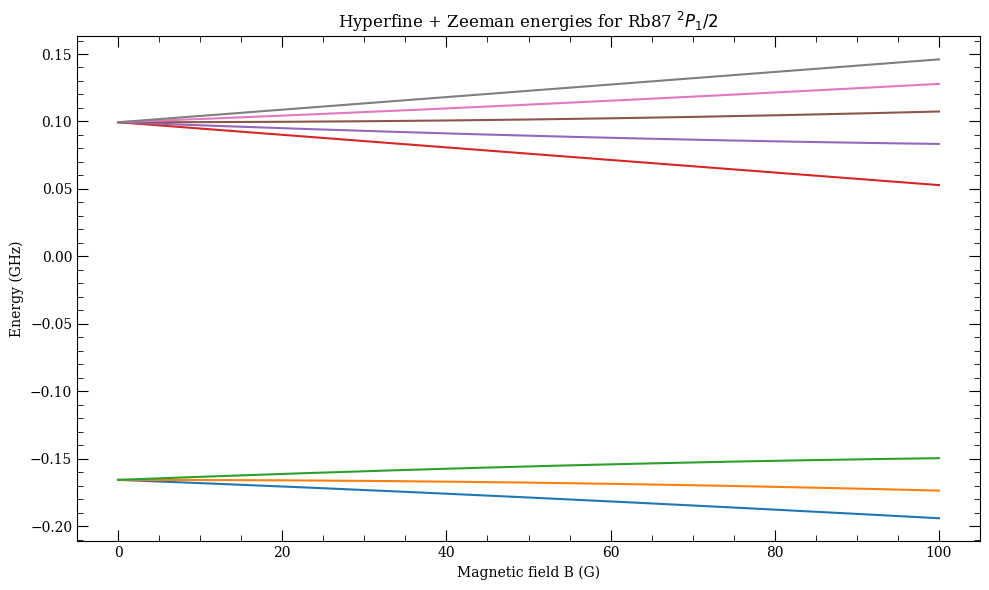

Zero-field eigenvalues (Hz):
 [-1.657e+08 -1.657e+08 -1.657e+08  9.942e+07  9.942e+07  9.942e+07
  9.942e+07  9.942e+07]
Basis ordering (mI, mJ):
 [(1.5, 0.5), (1.5, -0.5), (0.5, 0.5), (0.5, -0.5), (-0.5, 0.5), (-0.5, -0.5), (-1.5, 0.5), (-1.5, -0.5)]


In [ ]:
## User defined constants ##
atom = arc.Rubidium87()   # pick an atom
n = 6
L = 1
J = 0.5
S = 1/2 # For alkali atoms

# Calculated constants
gJ = lande_gJ(L, S, J, gL=atom.gL, gS=atom.gS)
gI = atom.gI             # nuclear g-factor (dimensionless, for use with μ_N)
I = atom.I              # nuclear spin
print(I)
A_hz, B_hz = atom.getHFSCoefficients(n=n, l=L, j=J) 

B_fields = np.linspace(0.0, 0.01, 201)  # in T
Bs, energies, basis = diagonalize_levels(I, J, A_hz=A_hz, B_hz=B_hz, gJ=gJ, gI=gI, B_fields=B_fields)

# Plot energy levels vs B (Hz)
plt.figure(figsize=(10,6))

for i in range(energies.shape[1]):
    plt.plot(Bs*1e4, energies[:, i]/1e9)
plt.xlabel("Magnetic field B (G)")
plt.ylabel("Energy (GHz)")
# plt.ylim([2e9,3e9])
plt.title(f"Hyperfine + Zeeman energies for {atom.elementName} ${spectroscopic_term(L=L, S=S, J=J)}$")
plt.tight_layout()
plt.show()

# Print zero-field eigenvalues (in Hz) and associated basis list for reference
H0, basis = build_hamiltonian(I, J, A_hz=A_hz, B_hz=B_hz, gJ=gJ, gI=gI, B_field=0.0)
eigs0 = la.eigvalsh(H0)
print("Zero-field eigenvalues (Hz):\n", np.sort(np.real(eigs0)))
print("Basis ordering (mI, mJ):\n", basis)

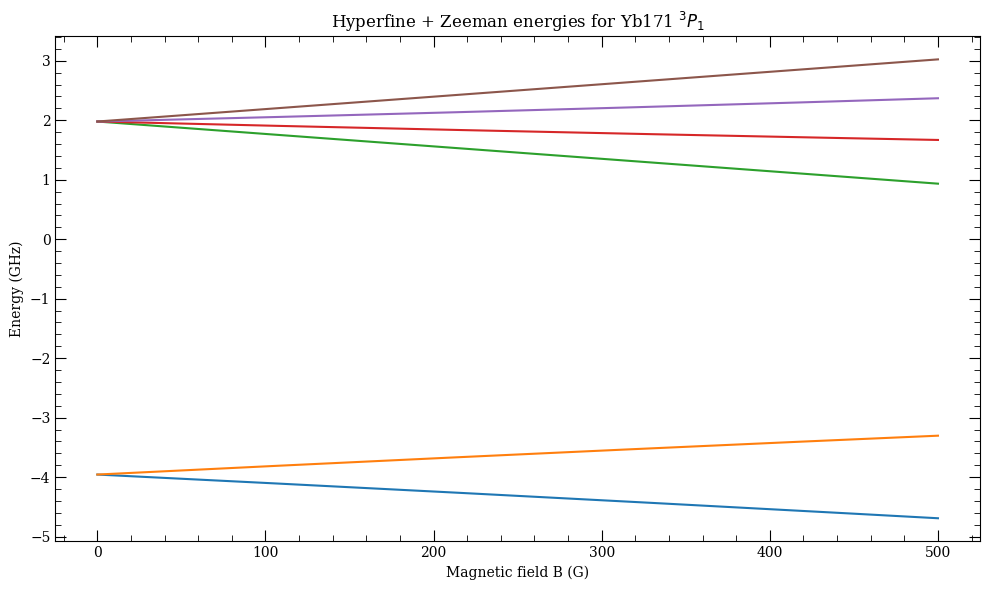

Zero-field eigenvalues (Hz):
 [-3.9570e+09 -3.9570e+09  1.9785e+09  1.9785e+09  1.9785e+09  1.9785e+09]
Basis ordering (mI, mJ):
 [(0.5, 1.0), (0.5, 0.0), (0.5, -1.0), (-0.5, 1.0), (-0.5, 0.0), (-0.5, -1.0)]


In [97]:
## 3P1 Yb171 constants ##
n = 6
L = 1
J = 1
S = 1 # For alkali atoms
gJ = 1.492820  #From https://arxiv.org/html/2509.04416v1
gI = 0.98734 #From https://arxiv.org/html/2509.04416v1
I = 1/2 
A_hz = 3.957e9 #From https://arxiv.org/html/2509.04416v1
B_hz = 0

B_fields = np.linspace(0.0, 0.05, 201) # in T
Bs, energies, basis = diagonalize_levels(I, J, A_hz=A_hz, B_hz=B_hz, gJ=gJ, gI=gI, B_fields=B_fields)

# Plot energy levels vs B (Hz)
plt.figure(figsize=(10,6))

for i in range(energies.shape[1]):
    plt.plot(Bs*1e4, energies[:, i]/1e9)
plt.xlabel("Magnetic field B (G)")
plt.ylabel("Energy (GHz)")
plt.title(f"Hyperfine + Zeeman energies for Yb171 ${spectroscopic_term(L=L, S=S, J=J)}$")
plt.tight_layout()
plt.show()

# Print zero-field eigenvalues (in Hz) and associated basis list for reference
H0, basis = build_hamiltonian(I, J, A_hz=A_hz, B_hz=B_hz, gJ=gJ, gI=gI, B_field=0.0)
eigs0 = la.eigvalsh(H0)
print("Zero-field eigenvalues (Hz):\n", np.sort(np.real(eigs0)))
print("Basis ordering (mI, mJ):\n", basis)

In [8]:
print(atom.elementName)

Rb87


## MOT Scattering
We want to calculate, in order
1. The scattering rate off of the MOT
2. The intensity of scattered MOT light
3. The intensity of scattered MOT light that reaches the atoms in tweezers
4. The detuning between lightshifted atoms in tweezers + scattered MOT light (gnd state)
5. The scattering rate of the tweezered atoms as a result of MOT light

In [ ]:
global h
h = 1

def scattering_rate(linewidth, intensity, isat, detuning):
    gamma = linewidth
    s0 = intensity/isat
    delta = detuning
    return (gamma/2) * (s0/(1 + s0 + (2*delta/gamma)**2))

def intensity_from_rate(Rsc, distance, frequency):
    # Each photon has energy hv, so power = Rsc * hv
    power = Rsc * h * frequency
    return power/(4*np.pi*(distance**2))

def MOT_tweezer_detuning()


In [ ]:
## Parameters from Steck
Rb_D1_linewidth = 36.105e6 # Hz
Rb_D1_Isat = 4.484 # mW / cm^2
Rb_detuning = Rb_D1_linewidth*2 # just set it to double linewidth for now
RB_MOT_intensity = 2 # W
transport_distance = 30 #cm
aperature_radius = 2 #cm
Rb_tweezer_depth = 0.8 #mK

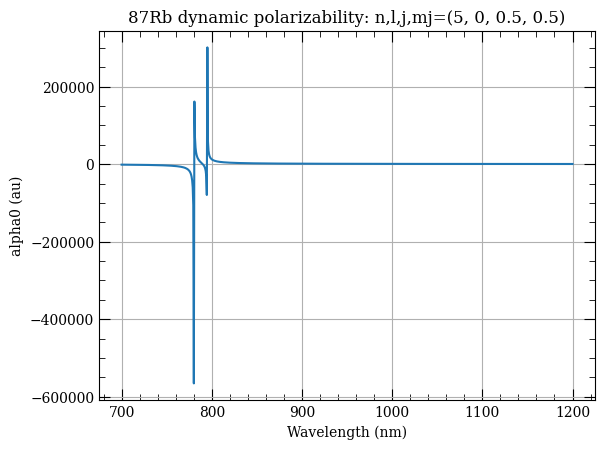

In [ ]:
"""
Dynamic (AC) polarizability of 87Rb vs wavelength using ARC.

Requires:
  pip install ARC-Alkali-Rydberg-Calculator numpy matplotlib

Notes:
- ARC's DynamicPolarizability is parameterized by fine-structure quantum numbers
  (n, l, j, mj), not hyperfine (F, mF).
- getPolarizability(...) returns (alpha0, alpha1, alpha2, core, dynamic, closestState).
  See ARC's ARC_3_0_introduction notebook for the returned tuple format. :contentReference[oaicite:0]{index=0}
"""

from __future__ import annotations

import numpy as np
import matplotlib.pyplot as plt

from arc import Rubidium87, DynamicPolarizability


def rb87_dynamic_polarizability_vs_wavelength(
    wavelengths_nm: np.ndarray,
    *,
    n: int = 5,
    l: int = 0,
    j: float = 0.5,
    mj: float = 0.5,
    n_min: int | None = None,
    n_max: int = 25,
    max_l: int = 4,
    units: str = "au",
    account_for_state_lifetime: bool = True,
):
    """
    Compute dynamic polarizability vs wavelength for 87Rb for a given (n,l,j,mj).

    Parameters
    ----------
    wavelengths_nm : array
        Wavelengths in nm.
    n,l,j,mj : state quantum numbers for |n l j mj>
        Example ground state: 5S1/2 => n=5, l=0, j=1/2.
    n_min, n_max, max_l : basis truncation parameters for ARC defineBasis
        If n_min is None, uses atom.groundStateN.
    units : "au" / "a.u." / etc.
        ARC supports "au" as used in their examples. :contentReference[oaicite:1]{index=1}
    account_for_state_lifetime : bool
        If True, ARC can include lifetime effects in the dynamic polarizability call. :contentReference[oaicite:2]{index=2}

    Returns
    -------
    result : dict of numpy arrays
        Keys: wavelength_nm, alpha0, alpha1, alpha2, core, dynamic
        (closestState is returned as a list of whatever ARC provides per point)
    """
    atom = Rubidium87()  # atomic data container :contentReference[oaicite:3]{index=3}
    calc = DynamicPolarizability(atom, n, l, j, mj)

    if n_min is None:
        n_min = atom.groundStateN

    # defineBasis signature used in ARC docs/examples :contentReference[oaicite:4]{index=4}
    calc.defineBasis(n_min, n_max)

    wl_m = np.asarray(wavelengths_nm, dtype=float) * 1e-9

    alpha0 = np.empty_like(wl_m)
    alpha1 = np.empty_like(wl_m)
    alpha2 = np.empty_like(wl_m)
    core = np.empty_like(wl_m)
    dynamic = np.empty_like(wl_m)
    closest = []

    for i, w in enumerate(wl_m):
        a0, a1, a2, c, d, closest_state = calc.getPolarizability(
            w, units=units, accountForStateLifetime=account_for_state_lifetime
        )
        alpha0[i] = a0
        alpha1[i] = a1
        alpha2[i] = a2
        core[i] = c
        dynamic[i] = d
        closest.append(closest_state)

    return {
        "wavelength_nm": np.asarray(wavelengths_nm, dtype=float),
        "alpha0": alpha0,
        "alpha1": alpha1,
        "alpha2": alpha2,
        "core": core,
        "dynamic": dynamic,
        "closestState": closest,
        "units": units,
        "state": (n, l, j, mj),
        "basis": (n_min, n_max, max_l),
    }


if __name__ == "__main__":
    # Example: 87Rb ground state 5S1/2 (mj=+1/2) from 700–1200 nm
    wls_nm = np.linspace(700.0, 1200.0, 800)

    out = rb87_dynamic_polarizability_vs_wavelength(
        wls_nm,
        n=5,
        l=0,
        j=0.5,
        mj=0.5,
        n_max=30,     # increase if you want more convergence
        max_l=4,
        units="au",
        account_for_state_lifetime=True,
    )

    # Total polarizability reported by ARC is often alpha0 + alpha2*(...) etc.,
    # but ARC already returns multiple components; many users plot alpha0 directly.
    # Here we plot alpha0 (scalar) as a simple default.
    plt.figure()
    plt.plot(out["wavelength_nm"], out["alpha0"])
    plt.xlabel("Wavelength (nm)")
    plt.ylabel(f"alpha0 ({out['units']})")
    plt.title(f"87Rb dynamic polarizability: n,l,j,mj={out['state']}")
    plt.grid(True)
    plt.show()
